## To Do

* Posterior predictive sampling
    * Univariate families **DONE**
    * Multivariate families
* Model string representation
* Model aliases **DONE**

## Examples working

* `alternative_links_binary.ipynb`
* `beta_regression.ipynb`
* `circular_regression.ipynb`
* `multi-level_regression.ipynb`
* `negative_binomial.ipynb`
* `sleepstudy.ipynb`
    * There's a xarray problem in a viz, not related to Bambi
* `splies_cherry_blossoms.ipynb`
    * Works, but needs updates because some things use old API
* `t_test.ipynb`
* `wald_gamma_glm.ipynb`

## Examples not working

* `categorical_regression.ipynb`
    * Fixed posterior predictive sampling, but the order of categories is broken
* `t_regression.ipynb`
    * There's a problem when creating the family

In [1]:
import bambi as bmb

In [2]:
#%load_ext autoreload
#%autoreload 2

In [3]:
data = bmb.load_data("my_data")

In [4]:
formula = bmb.Formula("y ~ x")
model = bmb.Model(formula, data)
model.build()

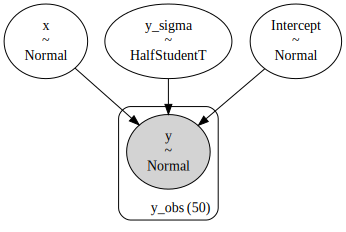

In [6]:
model.graph()

In [15]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, a, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [22]:
formula = bmb.Formula("y ~ x", "sigma ~ x")
model = bmb.Model(formula, data)
model.build()

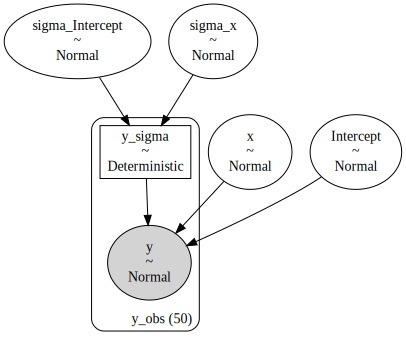

In [23]:
model.graph()

In [24]:
idata = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, x, sigma_Intercept, sigma_x]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


---

# Documentation notes

## Names

The logic is `{parent}_{child}`. The exception is the linear predictor of the main parameter, which is only `{child}`.

```python
bmb.Formula(
    "y ~ 1 + x + z",
    "sigma ~ 1 + x"
)
```

* `Intercept`
* `x`
* `z`
* `y_sigma`, the sigma parameter in the normal likelihood
* `sigma_Intercept`
* `sigma_x`

### Potential improvements

What about using just `sigma` instead of `{response_name}_sigma`. The gain: cleaner names. The downside: This pattern could be a conflict in a small number of cases where the name of predictors match the name of parameters in the likelihood. It could be "fixed" easily, by double checking the names of the predictors before creating the model.